In [1]:
import torch
import numpy as np
from numpy.linalg import *
import matplotlib.pyplot as plt
import h5py
import seaborn as sns


# importing sys
import sys

# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/home/jessica/Documentos/Codigo_Limpio/src/Python/src')
from LSTM_module import LSTM

# Enable interactive plot
%matplotlib inline
color = ['#83b692','#f9ada0', '#f9627d', '#c65b7c', '#5b3758']

# To latex plots:
from matplotlib import rc

rc('text', usetex=True)
rc('font',**{'family':'serif','serif':['Palatino']})

# Loading data test set

In [2]:
# To load the file

directory = '../data/DataNew/'
name_data = 'ngrid32_delta_20250319-203507.h5'
file_path = directory + name_data

# --- Load Data ---
with h5py.File(file_path, 'r') as h5f:
    X = h5f['dataset_X'][:]
    y = h5f['dataset_y'][:]

In [3]:
# --- Inspect Shape ---
X_shape = X.shape  # e.g., (num_trajectories, num_timesteps, num_features)

# --- Assign Shape Dimensions ---
num_trajectories, num_timesteps, num_features = X_shape

# --- Infer Structure ---
num_grid_points = num_features // 3  # assuming 3 features per grid point: real, imag, potential

# --- Print Information ---
print(" Data loaded from:", name_data)
print(f" Shape of X: {X_shape}")
print(f"  • Number of trajectories or total data      : {num_trajectories}")
print(f"  • Number of time steps (fs)                 : {num_timesteps}")
print(f"  • Total features per time step: {num_features}")
print(f"    ↳ Composed of:")
print(f"      - Real part     : {num_grid_points} grid points")
print(f"      - Imag part     : {num_grid_points} grid points")
print(f"      - Potential     : {num_grid_points} grid points")


 Data loaded from: ngrid32_delta_20250319-203507.h5
 Shape of X: (50, 200, 96)
  • Number of trajectories or total data      : 50
  • Number of time steps (fs)                 : 200
  • Total features per time step: 96
    ↳ Composed of:
      - Real part     : 32 grid points
      - Imag part     : 32 grid points
      - Potential     : 32 grid points


# Loading LSTM class and trained model

In [4]:
model = LSTM(
    hidden_size=1024,
    num_layers=2,
    seq_length=num_timesteps,
    num_output=2 * num_grid_points,
    input_size=3 * num_grid_points
)

If model was save with: `torch.save(model,'nameModel.pth')`  
⚠️ Not recommended for future projects

In [5]:
model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth', map_location='cpu')
model.eval()


/tmp/ipykernel_17156/1220633917.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/jessica/Documentos/Trained_LSTM_Models/model5b.pth', map_locati

LSTM(
  (lstm): LSTM(96, 1024, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1024, out_features=64, bias=True)
)

If model was save with `torch.save(model.state_dict(), 'model_name.pth')`, uncomment next  
✅ recommended

In [6]:

# Rebuild the model architecture
#model = MyLSTMModelClass(**your_parameters)

# Load weights safely to the desired device (CPU in this case)
#model.load_state_dict(torch.load('model_name.pth', map_location=torch.device('cpu')))
#model.eval()  # Set to inference mode

# Predicting a trajectory

- From here, we are going to suppouse that our LSTM model was trained using trajectories of 100 fs of duration.
- We want to predict the next 100 fs.

In [ ]:
def generate_sequence(model, initial_seq, potentials, steps_ahead, device):
    """
    Autoregressively generate a sequence using an LSTM model trained to predict deltas.
    
    Args:
        model: trained LSTM model
        initial_seq: tensor of shape (seq_len, input_dim) containing initial [ψ_real, ψ_imag, V]
        potentials: tensor of shape (total_steps, pot_dim) containing potentials for each step
        steps_ahead: int, how many future steps to generate
        device: torch.device
    
    Returns:
        predictions: list of predicted wavefunctions over time
    """
    model.eval()
    seq_len, input_dim = initial_seq.shape
    hidden = None

    # Start with the provided initial sequence
    current_seq = initial_seq.clone().to(device).unsqueeze(0)  # shape (1, seq_len, input_dim)

    # Store predictions (wavefunction only, not delta)
    predictions = []

    # Last known wavefunction (split from the input)
    psi = current_seq[-1, -1, :-potentials.shape[-1]]  # take last step wavefunction

    for t in range(steps_ahead):
        # Forward pass on the whole sequence
        delta_pred, hidden = model(current_seq, hidden)

        # Update wavefunction: ψ_{t+1} = ψ_t + Δψ
        psi = psi + delta_pred.squeeze(0)

        # Get potential for next step
        V_next = potentials[t].to(device)

        # Build new input vector = [ψ_real, ψ_imag, V]
        new_input = torch.cat([psi, V_next], dim=-1)

        # Roll the sequence: drop first, append new_input
        current_seq = torch.cat([current_seq[:, 1:], new_input.unsqueeze(0).unsqueeze(0)], dim=1)

        # Save predicted wavefunction
        predictions.append(psi.detach().cpu())

    return torch.stack(predictions)


In [6]:
trajectory_index = 20  # choose the one you want
seq_len = 100

# Extract the single trajectory for prediction
X_single = X[trajectory_index]  # shape: (timesteps, features)
# Ensure the sequence length is not longer than the available data
if seq_len > X_single.shape[0]:
    seq_len = X_single.shape[0]
input_seq = torch.tensor(X_single[:seq_len], dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_len, input_size)

# Extract the corresponding output
y_single = y[trajectory_index]  # shape: (timesteps, features)
output_seq = torch.tensor(y_single[:seq_len], dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_len, output_size)


In [18]:
import torch

def autoregressive_predict(model, X_single, seq_len, num_grid_points, device="cpu"):
    """
    Roll out predictions autoregressively for one trajectory.

    Args:
        model: trained LSTM model
        X_single: torch.Tensor, shape (timesteps, input_size)
                  One trajectory (Psi_real, Psi_imag, V)
        seq_len: int, number of steps used as input context
        num_grid_points: int, spatial grid size
        device: str, "cpu" or "cuda"
    Returns:
        pred_deltas: (pred_steps, 2*num_grid_points)
        pred_psi: (timesteps, 2*num_grid_points) reconstructed Psi_real, Psi_imag
    """
    model.eval()
    X_single = X_single.to(device)

    # take the first seq_len as initial context
    current_input_seq = X_single[:seq_len].unsqueeze(0).to(device)  # (1, seq_len, input_size)

    # initial Psi (we'll reconstruct full trajectory)
    psi_real = X_single[0, :num_grid_points]
    psi_imag = X_single[0, num_grid_points:2*num_grid_points]

    pred_deltas = []
    pred_psi = [X_single[t, :2*num_grid_points].cpu() for t in range(seq_len)]  
# store the true Psi(0..99) so indexing matches full trajectory

    #pred_psi = [torch.cat([psi_real, psi_imag], dim=-1)]  # start with Psi(0)

    for t in range(seq_len, X_single.shape[0]):
        with torch.no_grad():
            pred_all = model(current_input_seq)            # (1, seq_len, num_output)
            delta_t = pred_all[:, -1, :]                   # (1, num_output)

        pred_deltas.append(delta_t.squeeze(0).cpu())

        # extract last Psi(t) from current input
        last_input = current_input_seq[:, -1, :]           # (1, input_size)
        psi_real_t = last_input[:, :num_grid_points]
        psi_imag_t = last_input[:, num_grid_points:2*num_grid_points]
        V_t        = last_input[:, 2*num_grid_points:]

        # apply delta
        delta_real = delta_t[:, :num_grid_points]
        delta_imag = delta_t[:, num_grid_points:]
        psi_real_next = psi_real_t + delta_real
        psi_imag_next = psi_imag_t + delta_imag

        # save Psi(t+1)
        pred_psi.append(torch.cat([psi_real_next.squeeze(0),
                                   psi_imag_next.squeeze(0)], dim=-1).cpu())

        # build next input = (Psi_real_next, Psi_imag_next, same V_t)
        next_input = torch.cat([psi_real_next, psi_imag_next, V_t], dim=-1)  # (1, input_size)

        # append to rolling sequence
        current_input_seq = torch.cat([current_input_seq, next_input.unsqueeze(1)], dim=1)

    pred_deltas = torch.stack(pred_deltas, dim=0)  # (pred_steps, num_output)
    pred_psi = torch.stack(pred_psi, dim=0)        # (timesteps, 2*num_grid_points)

    return pred_deltas, pred_psi


In [19]:
trajectory_index = 20
seq_len = 100

X_single = torch.tensor(X[trajectory_index], dtype=torch.float32)
pred_deltas, pred_psi = autoregressive_predict(model, X_single, seq_len, num_grid_points, device)


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_wavefunction_comparison(true_X, pred_psi, timesteps, num_grid_points, grid_range=(-1.5, 1.5)):
    """
    Compare true vs predicted wavefunctions (real, imag, density) at given timesteps.

    Args:
        true_X: (timesteps, input_size) tensor or np.array, ground truth (Psi_real, Psi_imag, V)
        pred_psi: (timesteps, 2*num_grid_points) tensor, predicted Psi_real, Psi_imag
        timesteps: list of ints, which time indices to plot
        num_grid_points: int, spatial grid size
        grid_range: tuple, x-axis range for grid (optional)
    """
    if torch.is_tensor(true_X):
        true_X = true_X.cpu().numpy()
    if torch.is_tensor(pred_psi):
        pred_psi = pred_psi.cpu().numpy()

    r = np.linspace(grid_range[0], grid_range[1], num_grid_points)

    fig, axs = plt.subplots(len(timesteps), 3, figsize=(12, 3*len(timesteps)))

    if len(timesteps) == 1:
        axs = axs[np.newaxis, :]  # make 2D for consistency

    for i, t in enumerate(timesteps):
        # true Psi
        psi_real_true = true_X[t, :num_grid_points]
        psi_imag_true = true_X[t, num_grid_points:2*num_grid_points]
        density_true  = psi_real_true**2 + psi_imag_true**2

        # predicted Psi
        psi_real_pred = pred_psi[t, :num_grid_points]
        psi_imag_pred = pred_psi[t, num_grid_points:2*num_grid_points]
        density_pred  = psi_real_pred**2 + psi_imag_pred**2

        # Real part
        axs[i,0].plot(r, psi_real_true, label="True", color="black")
        axs[i,0].plot(r, psi_real_pred, "--", label="Pred", color="red")
        axs[i,0].set_title(f"Real part (t={t})")

        # Imag part
        axs[i,1].plot(r, psi_imag_true, label="True", color="black")
        axs[i,1].plot(r, psi_imag_pred, "--", label="Pred", color="red")
        axs[i,1].set_title(f"Imag part (t={t})")

        # Density
        axs[i,2].plot(r, density_true, label="True", color="black")
        axs[i,2].plot(r, density_pred, "--", label="Pred", color="red")
        axs[i,2].set_title(f"Density (t={t})")

        for j in range(3):
            axs[i,j].legend()
            axs[i,j].grid(True)

    plt.tight_layout()
    plt.show()


In [21]:
pred_psi.shape

torch.Size([200, 64])

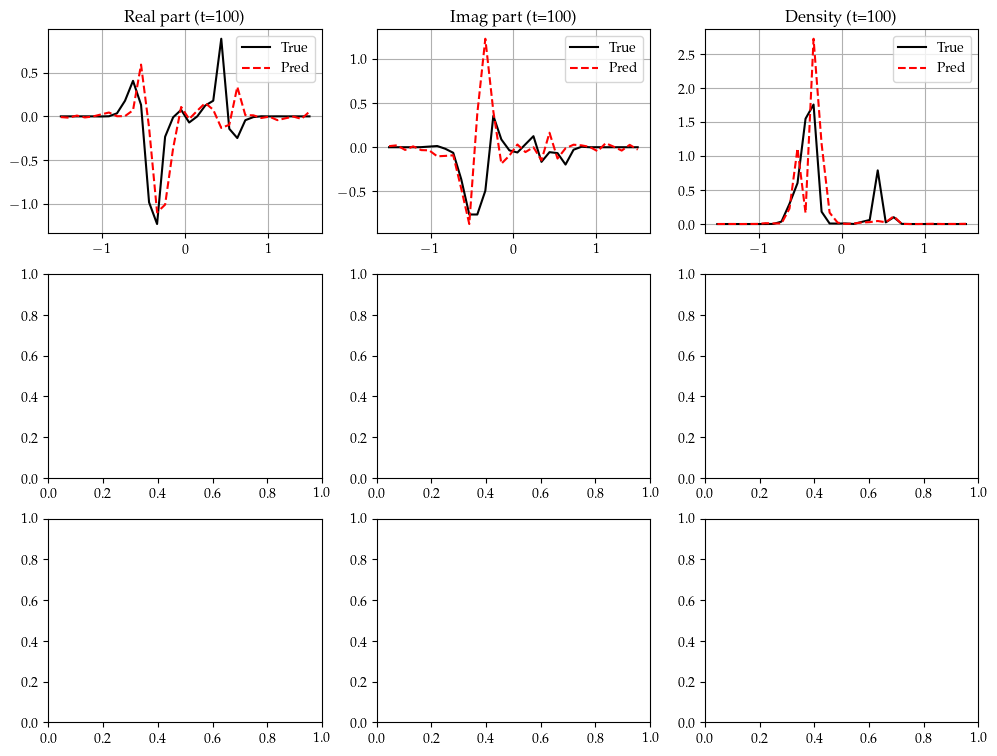

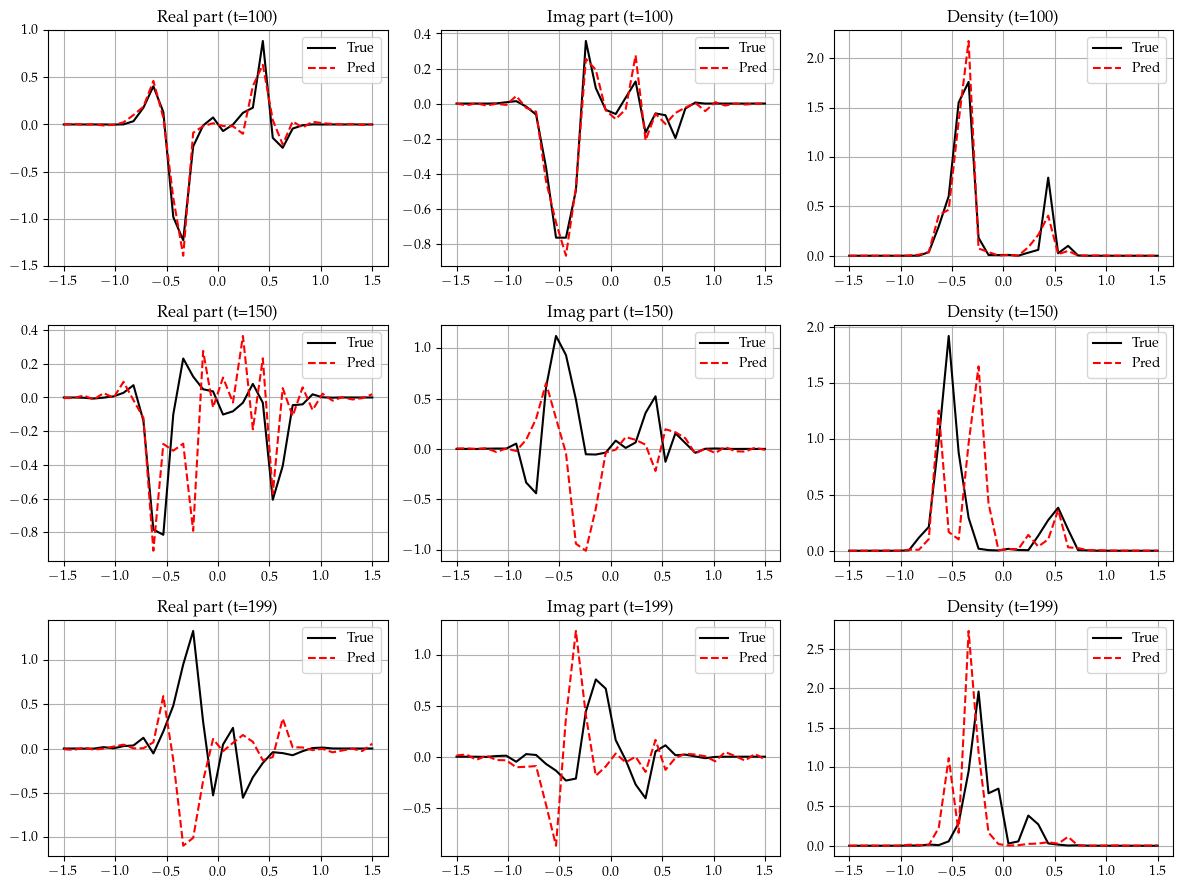

In [22]:
# ground truth for comparison
true_X = torch.tensor(X[trajectory_index], dtype=torch.float32)

# choose some time steps to check
timesteps_to_plot = [100, 150, 199]  # after roll-out

plot_wavefunction_comparison(true_X, pred_psi, timesteps_to_plot, num_grid_points)

In [161]:
with torch.no_grad():
    prediction_seq = model(input_seq)  # shape: (1, seq_len, output_size)
    

## Predicting a time step in a trajectory

In [162]:
def plot_wavefunction_prediction(Input, Output, Prediction, dat, time, grid_range=(-1.5,1.5), color=None):
    """    
    Plot the wavefunction prediction and compare it with the true values.
        Args:
        
        Input (torch.Tensor): Input tensor of shape (batch_size, time_steps, num_features).
        Output (torch.Tensor): True output tensor of shape (batch_size, time_steps, num_features).
        Prediction (torch.Tensor): Predicted output tensor of shape (batch_size, time_steps, num_features).
        dat (int): Index of the data sample to visualize.
        time (int): Time step to visualize.
        grid_range (tuple): Spatial range in Angstroms, default (-1.5, 1.5)
        color (list): List of colors for plotting.
    """

    num_grid_points = Input.shape[2] // 3  # Assuming 3 features per grid point: real, imag, potential
    # Create a grid of points in the range [a, b]
    a, b = grid_range
    r_n = np.linspace(a, b, num_grid_points)

    # Extract data from tensors
    pot = Input[dat, time, num_grid_points*2:num_grid_points*3].detach().cpu().numpy()
    
    in_real  = Input[dat, time, 0:num_grid_points].detach().cpu().numpy()
    in_imag  = Input[dat, time, num_grid_points:num_grid_points*2].detach().cpu().numpy()
    
    out_real = Output[dat, time, 0:num_grid_points].detach().cpu().numpy()
    out_imag = Output[dat, time, num_grid_points:num_grid_points*2].detach().cpu().numpy()
    
    pred_real = Prediction[dat, time, 0:num_grid_points].detach().cpu().numpy()
    pred_imag = Prediction[dat, time, num_grid_points:num_grid_points*2].detach().cpu().numpy()

    # Plot
    fig, axs = plt.subplots(2, 2)
    
    axs[0, 0].plot(r_n, pot*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
    axs[0, 0].plot(r_n, in_real*20, label="$\psi_{real}(r, t)$", color=color[0])

    axs[0, 1].plot(r_n, pot*(1/1.5936e-3), "-", label="$V(r,t)$", color=color[3])
    axs[0, 1].plot(r_n, in_imag*20, label="$\psi_{imag}(r, t)$", color=color[1])

    axs[1, 0].plot(r_n, (out_real + in_real)*20, label="$\psi_{real}(r, t+1)_{True}$", color=color[0])
    axs[1, 0].scatter(r_n, (pred_real + in_real)*20, label="$\psi_{real}(r, t+1)_{LSTM}$", color=color[4], marker='.')

    axs[1, 1].plot(r_n, (out_imag + in_imag)*20, label="$\psi_{imag}(r, t+1)_{True}$", color=color[1])
    axs[1, 1].scatter(r_n, (pred_imag + in_imag)*20, label="$\psi_{imag}(r, t+1)_{LSTM}$", color=color[4], marker='.')

    for ax in axs.flat:
        ax.label_outer()
        ax.set_ylim([-35, 50])
        ax.set(xlabel='Position [$\AA$]')
        ax.legend()

    plt.gcf().set_size_inches(8, 5.33)
    plt.tight_layout()
    plt.show()


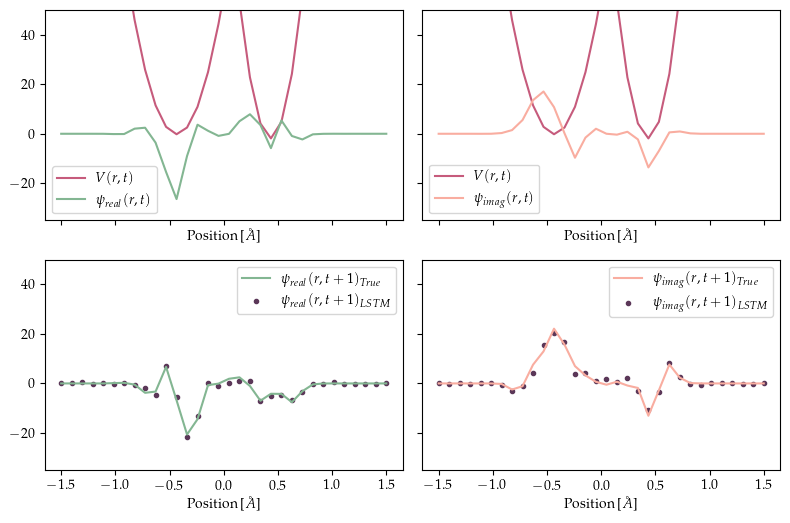

In [163]:
# Call the function with your sample index and time
plot_wavefunction_prediction(Input=input_seq, Output=output_seq, Prediction=prediction_seq, dat=0, time=102, color=color)


## Predicting density trajectory

In [164]:
import matplotlib.pyplot as plt
import numpy as np

def plot_density_evolution_from_tensors(Input, Output, Prediction, times_to_plot, grid_range=(-1.5, 1.5), color=None):
    """
    Plot wavefunction density and potential for selected time steps using the LSTM input/output/prediction structure.

    Args:
        Input (torch.Tensor): shape (batch_size, time_steps, 3 * num_grid_points)
        Output (torch.Tensor): shape (batch_size, time_steps, 2 * num_grid_points)  # true Δψ
        Prediction (torch.Tensor): same shape as Output                              # predicted Δψ
        times_to_plot (list): list of time step indices to plot
        grid_range (tuple): (min, max) range for the spatial grid
        color (list or None): optional list of colors
    """
    batch = 0  # assuming we're plotting only the first trajectory
    num_grid_points = Input.shape[-1] // 3
    a, b = grid_range
    r_n = np.linspace(a, b, num_grid_points)
    scale_factor = 10  # To plot wavefunction in the same plot that potential

    if color is None:
        color = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # true, pred, potential

    n_plots = len(times_to_plot)
    n_rows, n_cols = 3, 2  # fixed layout

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
    axs = axs.flatten()

    for i, t in enumerate(times_to_plot):
        # Get ψ(t) from input
        psi_real_t = Input[batch, t, :num_grid_points]
        psi_imag_t = Input[batch, t, num_grid_points:2*num_grid_points]

        # Get Δψ from Output and Prediction
        dpsi_real_true = Output[batch, t, :num_grid_points]
        dpsi_imag_true = Output[batch, t, num_grid_points:]
        dpsi_real_pred = Prediction[batch, t, :num_grid_points]
        dpsi_imag_pred = Prediction[batch, t, num_grid_points:]

        # Compute ψ(t+1)
        psi_real_true_next = psi_real_t + dpsi_real_true
        psi_imag_true_next = psi_imag_t + dpsi_imag_true
        psi_real_pred_next = psi_real_t + dpsi_real_pred
        psi_imag_pred_next = psi_imag_t + dpsi_imag_pred

        # Compute densities
        density_true = psi_real_true_next**2 + psi_imag_true_next**2
        density_pred = psi_real_pred_next**2 + psi_imag_pred_next**2

        # Get potential, Energy: au -> kcal/mol
        V_t = Input[batch, t, 2*num_grid_points:] * (1/1.5936e-3)

        # Plotting
        axs[i].plot(r_n, density_true * scale_factor, label="True", color='C0')
        axs[i].scatter(r_n, density_pred * scale_factor, label="Pred", color=color[4], marker='.')
        axs[i].plot(r_n, V_t, label="Potential", color=color[3])
        axs[i].set_title(f"t = {t} fs")
        axs[i].set_xlabel('Position [$\AA$]')
        axs[i].set_ylim([-15, 50])

    # Hide any unused subplots (in case times_to_plot < 6)
    for j in range(n_plots, n_rows * n_cols):
        axs[j].axis('off')

    axs[0].set_ylabel("Density / Potential")
    axs[0].legend(loc="upper right")
    plt.tight_layout()
    plt.show()


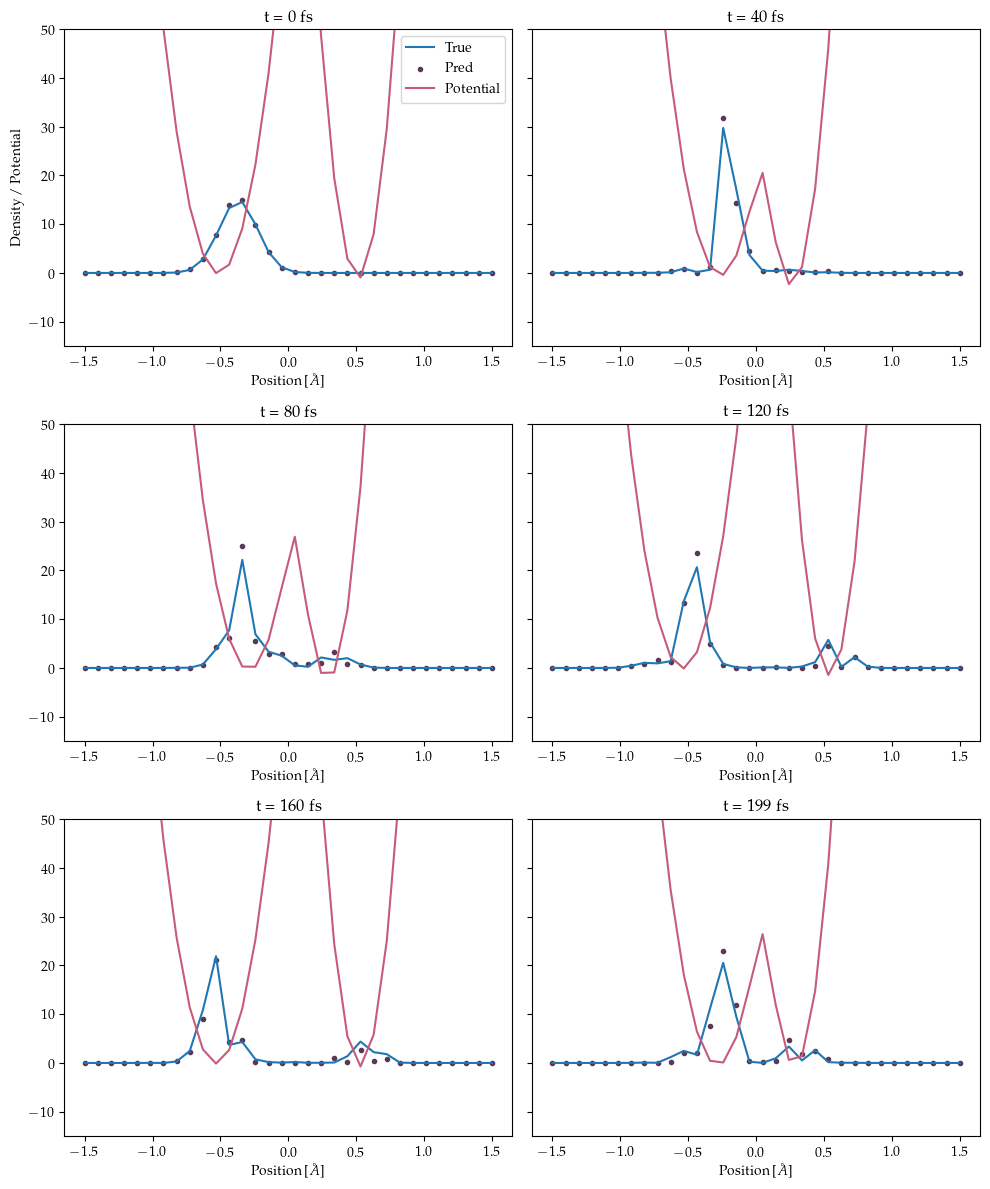

In [165]:
times_to_show = [0, 40, 80, 120, 160, 199]
plot_density_evolution_from_tensors(Input=input_seq, Output=output_seq, Prediction=prediction_seq, times_to_plot=times_to_show, color=color)


## Heat maps

In [166]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_wavefunction_heatmap(X, dat=0, grid_range=(-1.5, 1.5), n_xticks=5, 
                              n_yticks=4, save_path=None,
                              time_slice=None,
                              is_delta=False,
                              initial_input=None):
    """
    Plots a heatmap of |psi(r, t)|^2 over space and time (optionally sliced in time).
    
    Parameters:
        X (tensor): Input tensor of shape (trajectories, timesteps, features).
                    Can be actual ψ or Δψ.
        dat (int): Trajectory index.
        grid_range (tuple): (min, max) range of spatial domain in Angstroms.
        n_xticks (int): Number of ticks on the time axis.
        n_yticks (int): Number of ticks on the position axis.
        save_path (str or None): If provided, saves the plot to this path.
        time_slice (tuple or None): Optional (start, end) indices to slice the time axis.
        is_delta (bool): If True, assumes X contains Δψ and reconstructs ψ.
        initial_input (tensor or None): Required if is_delta=True.
                                        Should be the original input tensor to extract ψ(t=0).
    """

    num_trajectories, num_timesteps, num_features = X.shape
    num_grid_points = num_features // 2 if is_delta else num_features // 3
    time_range_fs = num_timesteps

    assert dat < num_trajectories, f"Trajectory index {dat} out of bounds!"

    # Spatial grid
    r_n = torch.linspace(grid_range[0], grid_range[1], num_grid_points)

    # Slice the time dimension if requested
    if time_slice:
        start, end = time_slice
        assert 0 <= start < end <= num_timesteps, "Invalid time_slice indices!"
        X_segment = X[dat, start:end, :]
        timesteps_to_plot = end - start
    else:
        X_segment = X[dat, :, :]
        timesteps_to_plot = num_timesteps
        start = 0  # for labels

    # Handle Δψ input: reconstruct ψ from initial ψ and deltas
    if is_delta:
        assert initial_input is not None, "initial_input is required when is_delta=True"
        psi_real = [initial_input[dat, 0, :num_grid_points]]
        psi_imag = [initial_input[dat, 0, num_grid_points:2*num_grid_points]]

        for t in range(X_segment.shape[0]):
            dpsi_real = X_segment[t, :num_grid_points]
            dpsi_imag = X_segment[t, num_grid_points:]
            psi_real.append(psi_real[-1] + dpsi_real)
            psi_imag.append(psi_imag[-1] + dpsi_imag)

        psi_real = torch.stack(psi_real[1:])  # discard initial copy
        psi_imag = torch.stack(psi_imag[1:])
    else:
        psi_real = X_segment[:, :num_grid_points]
        psi_imag = X_segment[:, num_grid_points:2*num_grid_points]

    # Compute density
    X_complex = np.vectorize(complex)(psi_real.T, psi_imag.T)
    X_dens = np.abs(X_complex)**2

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(8, 5))
    sns.heatmap(X_dens, cbar_kws={'label': r'$|\psi(r,t)|^2$ [$1/\mathrm{\AA}$]'}, ax=ax)

    # --- X-axis (time) ---
    xtick_locs = np.linspace(0, timesteps_to_plot, n_xticks, dtype=int)
    if time_range_fs:
        total_fs = time_range_fs * (timesteps_to_plot / num_timesteps)
        xtick_labels = [f"{int(total_fs * i / (timesteps_to_plot)) + int(start * (time_range_fs / num_timesteps))}" for i in xtick_locs]
        ax.set_xlabel("Time [fs]")
    else:
        xtick_labels = [str(i + start) for i in xtick_locs]
        ax.set_xlabel("Time [steps]")
    ax.set_xticks(xtick_locs)
    ax.set_xticklabels(xtick_labels)

    # Optional vertical markers
    for t in [250, 500, 750]:
        ax.axvline(x=t, color='white', linestyle='--', linewidth=1, alpha=0.2)

    # --- Y-axis (position) ---
    ytick_locs = np.linspace(0, num_grid_points - 1, n_yticks, dtype=int)
    ytick_labels = np.linspace(grid_range[0], grid_range[1], n_yticks)
    ax.set_yticks(ytick_locs)
    ax.set_yticklabels([f"{y:.1f}" for y in ytick_labels])
    ax.set_ylabel("Position [$\mathrm{\AA}$]")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Heatmap saved to: {save_path}")
    plt.show()


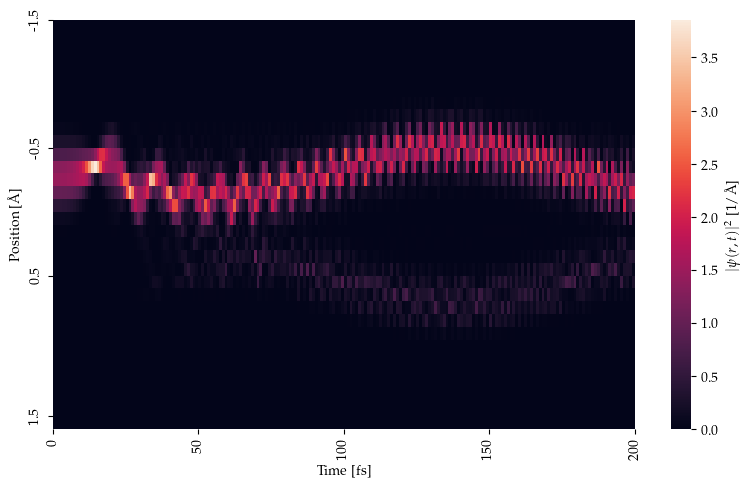

In [167]:
plot_wavefunction_heatmap(X=output_seq, dat=0, is_delta=True, initial_input=input_seq)

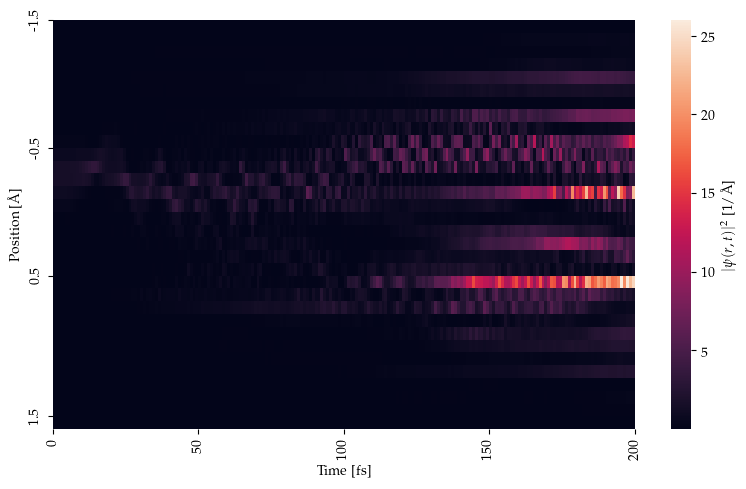

In [168]:
plot_wavefunction_heatmap(X=prediction_seq, dat=0, is_delta=True, initial_input=input_seq)


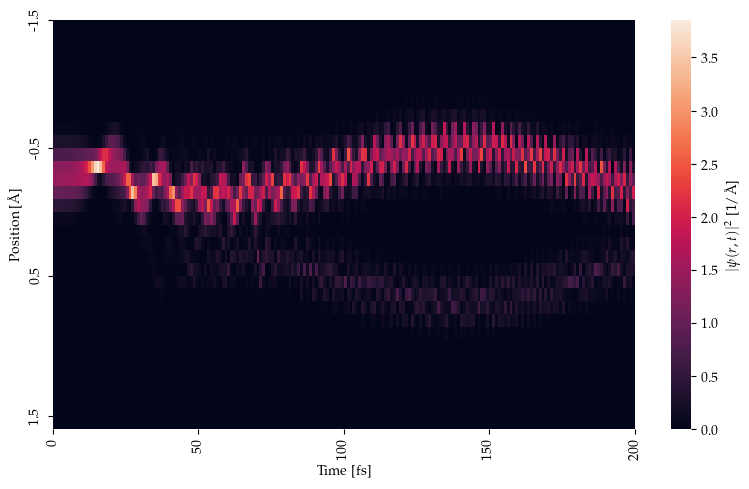

In [ ]:
plot_wavefunction_heatmap(X=input_seq, dat=0)
# It would be the same as the output, but without the initial wavefunction at t=0.

In [1]:
print("This is the end of the notebook. Happy day 😁")

This is the end of the notebook. Happy day 😁
